In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:

def getConserved( rho, vx, vy, P, gamma, vol ):
	"""
    Calculate the conserved variable from the primitive
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	gamma    is ideal gas gamma
	vol      is cell volume
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	"""
	Mass   = rho * vol
	Momx   = rho * vx * vol
	Momy   = rho * vy * vol
	Energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol
	
	return Mass, Momx, Momy, Energy


def getPrimitive( Mass, Momx, Momy, Energy, gamma, vol ):
	"""
    Calculate the primitive variable from the conservative
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	gamma    is ideal gas gamma
	vol      is cell volume
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""
	rho = Mass / vol
	vx  = Momx / rho / vol
	vy  = Momy / rho / vol
	P   = (Energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)
	
	return rho, vx, vy, P


def getGradient(f, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	f_dx = ( np.roll(f,R,axis=0) - np.roll(f,L,axis=0) ) / (2*dx)
	f_dy = ( np.roll(f,R,axis=1) - np.roll(f,L,axis=1) ) / (2*dx)
	
	return f_dx, f_dy


def slopeLimit(f, dx, f_dx, f_dy):
	"""
    Apply slope limiter to slopes
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	f_dx = np.maximum(0., np.minimum(1., ( (f-np.roll(f,L,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dx = np.maximum(0., np.minimum(1., (-(f-np.roll(f,R,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dy = np.maximum(0., np.minimum(1., ( (f-np.roll(f,L,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy
	f_dy = np.maximum(0., np.minimum(1., (-(f-np.roll(f,R,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy
	
	return f_dx, f_dy


def extrapolateInSpaceToFace(f, f_dx, f_dy, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	f_dx     is a matrix of the field x-derivatives
	f_dy     is a matrix of the field y-derivatives
	dx       is the cell size
	f_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis 
	f_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis 
	f_YL     is a matrix of spatial-extrapolated values on `left' face along y-axis 
	f_YR     is a matrix of spatial-extrapolated values on `right' face along y-axis 
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	f_XL = f - f_dx * dx/2
	f_XL = np.roll(f_XL,R,axis=0)
	f_XR = f + f_dx * dx/2
	
	f_YL = f - f_dy * dx/2
	f_YL = np.roll(f_YL,R,axis=1)
	f_YR = f + f_dy * dx/2
	
	return f_XL, f_XR, f_YL, f_YR
	

def applyFluxes(F, flux_F_X, flux_F_Y, dx, dt):
	"""
    Apply fluxes to conserved variables
	F        is a matrix of the conserved variable field
	flux_F_X is a matrix of the x-dir fluxes
	flux_F_Y is a matrix of the y-dir fluxes
	dx       is the cell size
	dt       is the timestep
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	# update solution
	F += - dt * dx * flux_F_X
	F +=   dt * dx * np.roll(flux_F_X,L,axis=0)
	F += - dt * dx * flux_F_Y
	F +=   dt * dx * np.roll(flux_F_Y,L,axis=1)
	
	return F


def getFlux(rho_L, rho_R, vx_L, vx_R, vy_L, vy_R, P_L, P_R, gamma):
	"""
    Calculate fluxed between 2 states with local Lax-Friedrichs/Rusanov rule 
	rho_L        is a matrix of left-state  density
	rho_R        is a matrix of right-state density
	vx_L         is a matrix of left-state  x-velocity
	vx_R         is a matrix of right-state x-velocity
	vy_L         is a matrix of left-state  y-velocity
	vy_R         is a matrix of right-state y-velocity
	P_L          is a matrix of left-state  pressure
	P_R          is a matrix of right-state pressure
	gamma        is the ideal gas gamma
	flux_Mass    is the matrix of mass fluxes
	flux_Momx    is the matrix of x-momentum fluxes
	flux_Momy    is the matrix of y-momentum fluxes
	flux_Energy  is the matrix of energy fluxes
	"""
	
	# left and right energies
	en_L = P_L/(gamma-1)+0.5*rho_L * (vx_L**2+vy_L**2)
	en_R = P_R/(gamma-1)+0.5*rho_R * (vx_R**2+vy_R**2)

	# compute star (averaged) states
	rho_star  = 0.5*(rho_L + rho_R)
	momx_star = 0.5*(rho_L * vx_L + rho_R * vx_R)
	momy_star = 0.5*(rho_L * vy_L + rho_R * vy_R)
	en_star   = 0.5*(en_L + en_R)
	
	P_star = (gamma-1)*(en_star-0.5*(momx_star**2+momy_star**2)/rho_star)
	
	# compute fluxes (local Lax-Friedrichs/Rusanov)
	flux_Mass   = momx_star
	flux_Momx   = momx_star**2/rho_star + P_star
	flux_Momy   = momx_star * momy_star/rho_star
	flux_Energy = (en_star+P_star) * momx_star/rho_star
	
	# find wavespeeds
	C_L = np.sqrt(gamma*P_L/rho_L) + np.abs(vx_L)
	C_R = np.sqrt(gamma*P_R/rho_R) + np.abs(vx_R)
	C = np.maximum( C_L, C_R )
	
	# add stabilizing diffusive term
	flux_Mass   -= C * 0.5 * (rho_L - rho_R)
	flux_Momx   -= C * 0.5 * (rho_L * vx_L - rho_R * vx_R)
	flux_Momy   -= C * 0.5 * (rho_L * vy_L - rho_R * vy_R)
	flux_Energy -= C * 0.5 * ( en_L - en_R )

	return flux_Mass, flux_Momx, flux_Momy, flux_Energy

In [3]:
""" Finite Volume simulation """

# Simulation parameters
N                      = 128 # resolution
boxsize                = 1.
gamma                  = 5/3 # ideal gas gamma
courant_fac            = 0.4
t                      = 0
tEnd                   = 2
tOut                   = 0.02 # draw frequency
useSlopeLimiting       = False
plotRealTime = True # switch on for plotting as the simulation goes along

# Mesh
dx = boxsize / N
vol = dx**2
xlin = np.linspace(0.5*dx, boxsize-0.5*dx, N)
Y, X = np.meshgrid( xlin, xlin )

# Generate Initial Conditions - gas expanding from a point in the center
w0 = 0.1
sigma = 0.05/np.sqrt(2.)

rho = 1. + 0.1 * np.exp(-(X-0.5)**2/(2 * sigma**2)) * np.exp(-(Y-0.5)**2/(2*sigma**2))
# vx = 0.5 + 0.1 * np.exp(-(X-0.5)**2/(2 * sigma**2)) * np.exp(-(Y-0.5)**2/(2*sigma**2))
# vy = 0. + w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )
P = 2.5 * np.ones(X.shape)

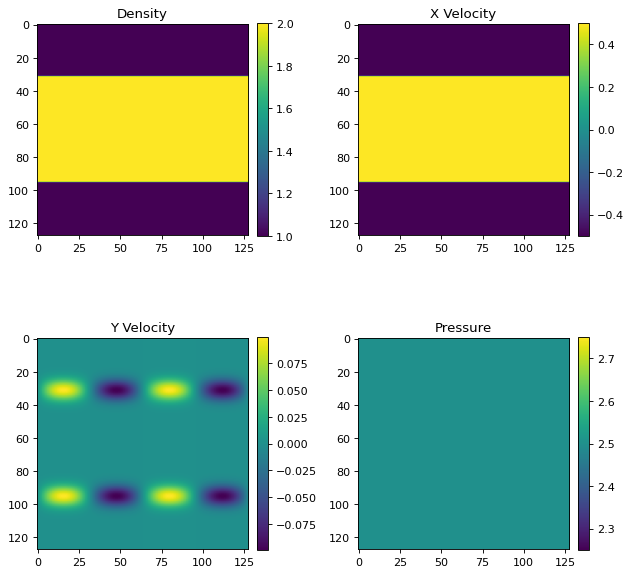

In [19]:
# Generate Initial Conditions - ball of dense gas expanding from center
w0 = 0.1 # perturbation amplitude
sigma = 0.05/np.sqrt(2.) # perturbation width
rho = 1. + (np.abs(Y-0.5) < 0.25) # density - 1 in the middle, 0.125 on the sides
vx = -0.5 + (np.abs(Y-0.5)<0.25) # x-velocity
vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )
P = 2.5 * np.ones(X.shape)

# Display all aspects of the initial conditions
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=80)
im0 = ax[0, 0].imshow(rho.T)
ax[0, 0].set_title('Density')
fig.colorbar(im0, ax=ax[0, 0], fraction=0.046, pad=0.04)
im1 = ax[0, 1].imshow(vx.T)
ax[0, 1].set_title('X Velocity')
fig.colorbar(im1, ax=ax[0, 1], fraction=0.046, pad=0.04)
im2 = ax[1, 0].imshow(vy.T)
ax[1, 0].set_title('Y Velocity')
fig.colorbar(im2, ax=ax[1, 0], fraction=0.046, pad=0.04)
im3 = ax[1, 1].imshow(P.T)
ax[1, 1].set_title('Pressure')
fig.colorbar(im3, ax=ax[1, 1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:

# Generate Initial Conditions - opposite moving streams with perturbation
# w0 = 0.1 # perturbation amplitude
# sigma = 0.05/np.sqrt(2.) # perturbation width
# rho = 1. + (np.abs(Y-0.5) < 0.25) # density - 1 in the middle, 0.125 on the sides
# vx = -0.5 + (np.abs(Y-0.5)<0.25) # x-velocity
# vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )
# P = 2.5 * np.ones(X.shape)


# Get conserved variables
Mass, Momx, Momy, Energy = getConserved( rho, vx, vy, P, gamma, vol )

# prep figure
fig = plt.figure(figsize=(4,4), dpi=80)
outputCount = 1

# Simulation Main Loop
while t < tEnd:
	
	# get Primitive variables
	rho, vx, vy, P = getPrimitive( Mass, Momx, Momy, Energy, gamma, vol )
	
	# get time step (CFL) = dx / max signal speed
	dt = courant_fac * np.min( dx / (np.sqrt( gamma*P/rho ) + np.sqrt(vx**2+vy**2)) )
	plotThisTurn = False
	if t + dt > outputCount*tOut:
		dt = outputCount*tOut - t
		plotThisTurn = True
	
	# calculate gradients
	rho_dx, rho_dy = getGradient(rho, dx)
	vx_dx,  vx_dy  = getGradient(vx,  dx)
	vy_dx,  vy_dy  = getGradient(vy,  dx)
	P_dx,   P_dy   = getGradient(P,   dx)
	
	# slope limit gradients
	if useSlopeLimiting:
		rho_dx, rho_dy = slopeLimit(rho, dx, rho_dx, rho_dy)
		vx_dx,  vx_dy  = slopeLimit(vx , dx, vx_dx,  vx_dy )
		vy_dx,  vy_dy  = slopeLimit(vy , dx, vy_dx,  vy_dy )
		P_dx,   P_dy   = slopeLimit(P  , dx, P_dx,   P_dy  )
	
	# extrapolate half-step in time
	rho_prime = rho - 0.5*dt * ( vx * rho_dx + rho * vx_dx + vy * rho_dy + rho * vy_dy)
	vx_prime  = vx  - 0.5*dt * ( vx * vx_dx + vy * vx_dy + (1/rho) * P_dx )
	vy_prime  = vy  - 0.5*dt * ( vx * vy_dx + vy * vy_dy + (1/rho) * P_dy )
	P_prime   = P   - 0.5*dt * ( gamma*P * (vx_dx + vy_dy)  + vx * P_dx + vy * P_dy )
	
	# extrapolate in space to face centers
	rho_XL, rho_XR, rho_YL, rho_YR = extrapolateInSpaceToFace(rho_prime, rho_dx, rho_dy, dx)
	vx_XL,  vx_XR,  vx_YL,  vx_YR  = extrapolateInSpaceToFace(vx_prime,  vx_dx,  vx_dy,  dx)
	vy_XL,  vy_XR,  vy_YL,  vy_YR  = extrapolateInSpaceToFace(vy_prime,  vy_dx,  vy_dy,  dx)
	P_XL,   P_XR,   P_YL,   P_YR   = extrapolateInSpaceToFace(P_prime,   P_dx,   P_dy,   dx)
	
	# compute fluxes (local Lax-Friedrichs/Rusanov)
	flux_Mass_X, flux_Momx_X, flux_Momy_X, flux_Energy_X = getFlux(rho_XL, rho_XR, vx_XL, vx_XR, vy_XL, vy_XR, P_XL, P_XR, gamma)
	flux_Mass_Y, flux_Momy_Y, flux_Momx_Y, flux_Energy_Y = getFlux(rho_YL, rho_YR, vy_YL, vy_YR, vx_YL, vx_YR, P_YL, P_YR, gamma)
	
	# update solution
	Mass   = applyFluxes(Mass, flux_Mass_X, flux_Mass_Y, dx, dt)
	Momx   = applyFluxes(Momx, flux_Momx_X, flux_Momx_Y, dx, dt)
	Momy   = applyFluxes(Momy, flux_Momy_X, flux_Momy_Y, dx, dt)
	Energy = applyFluxes(Energy, flux_Energy_X, flux_Energy_Y, dx, dt)
	
	# update time
	t += dt
	
	# plot in real time - color 1/2 particles blue, other half red
	if (plotRealTime and plotThisTurn) or (t >= tEnd):
		plt.cla()
		plt.imshow(rho.T)
		plt.clim(0.8, 2.2)
		ax = plt.gca()
		ax.invert_yaxis()
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)	
		ax.set_aspect('equal')	
		plt.pause(0.001)
		outputCount += 1
		

# Save figure
plt.savefig('finitevolume.png',dpi=240)
plt.show()